In [ ]:
df = pd.read_csv("data/entity_education.tsv", header=None)

pd.set_option('display.max_colwidth', -1)
df.head(2)

In [1]:
import pandas as pd
import numpy as np
import os
import wikipedia
import requests
from threading import Lock
import re
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [3]:
# %load links/utils.py
QUERY_DICT = {'Organization Founded By^-1':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P112 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                           ],
              'Organization Founded By':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P112 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                        ],
              'Organization Headquarters':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P159 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                          ],
              'Organization Subsidiary Of^-1':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P355 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                              ],
              'Organization Subsidiary Of':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P355 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                           ],
              'Organization top employees':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P169 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""", # CEO
                                            """SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P488 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""" # Chairperson
                                            ],
              'Person Employee or Member of^-1':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P108 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""",
                                            """SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P527 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""" 
                                                ],
              'Person Employee or Member of':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P108 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""",
                                              """SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P463 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""## member of ---> Band Members
                                            ],
              'Person Place of Birth':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P19 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                      ],
              'Person Current and Past Location of Residence':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P551 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                                              ],
              'Person Parents':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P22 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""", #Father
                                """SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P25 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""", #Mother
                                """SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P1038 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""" #Relative (Adopted Parents?)
                                # Shall we include stepparents??
                               ],
              'Person Parents^-1':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P40 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                  ],
              'Person Siblings':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P3373 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                ],
              'Person Spouse':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P26 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                              ],
              'Citizen of':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P27 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                           ],
              'Educated at':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P69 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                            ]
             }




from SPARQLWrapper import SPARQLWrapper, JSON   
from rosette.api import API, DocumentParameters, RosetteException
import pandas as pd
import wikipedia
import requests
import numpy as np
import pickle
import random
from threading import Lock
import os, sys
import threading
from threading import Thread
import time
import queue

class Utils:
    
    def __init__(self):
        self.id_dict = {}
        self.lock = Lock()
        self.load_dict()
        
    
    def __del__(self):
        self.save_dict()

    def get_id(self, message, dict_to_use=None):
#         if dict_to_use:
#             dict_to_use = dict_to_use
#         else:
#             global id_dict
#             dict_to_use = id_dict
    
        if message in self.id_dict:
            return self.id_dict[message]
        else:
            API_ENDPOINT = "https://www.wikidata.org/w/api.php"
            query = message
            params = {
                'action': 'wbsearchentities',
                'format': 'json',
                'language': 'en',
                'search': query
            }
            r = requests.get(API_ENDPOINT, params = params)
            try:
                with self.lock:
                    self.id_dict[message] = r.json()['search'][0]['id']
                return self.id_dict[message]
            except Exception:
                return -1 #The id doesn't exist


    def id_to_name(self, eid):
#         if dict_to_use:
#             dict_to_use = dict_to_use
#         else:
#             global id_dict
#             dict_to_use = id_dict

        if eid in self.id_dict.values():
            return [key for key, value in self.id_dict.items() if value == eid][0]
        else:
            API_ENDPOINT = "https://www.wikidata.org/w/api.php"
            query = eid
            params = {
                'action': 'wbsearchentities',
                'format': 'json',
                'language': 'en',
                'search': query
            }
            r = requests.get(API_ENDPOINT, params = params)
            try:
                with self.lock:
                    self.id_dict[ r.json()['search'][0]['label'] ] = r.json()['search'][0]['id']
                return r.json()['search'][0]['label']
            except Exception:
                return -1 #The id doesn't exist


    def get_results(self, query, value, endpoint_url="https://query.wikidata.org/sparql"):
        sparql = SPARQLWrapper(endpoint_url)
        sparql.setQuery(query%value)
        sparql.setReturnFormat(JSON)
        return sparql.query().convert()


    def ground_truth(self, relation, subject, debug=False):
        global QUERY_DICT
        results = []
        gt = []
        try:
            results = [self.get_results(query, self.get_id(subject)) for query in QUERY_DICT[relation]]
            for result in results:
                for r in result["results"]["bindings"]:
                    gt.append(r['itemLabel']['value'])
        except:
            if debug:
                print (relation, subject)
        return gt

    def add_ground_truth(self, df, debug=False):
        if df.empty:
            return df
        if debug:
            print (df)
        df = df.reset_index()
        df['Pseudo Ground Truth'] = df.apply(lambda row: self.ground_truth(row['Relationship'], row['Subject']), axis=1)
        df['Count_PGT'] = df['Pseudo Ground Truth'].apply(lambda x: len(x))
        df = df.set_index(['Subject','Relationship'])
        return df

    def add_recall_score(self, df):
        df['Recall Prediction'] = np.random.randint(0, 100, df.shape[0])/100
        return df


    def load_dict(self):
        try:
            with open('data/dumps/id_dict.pkl', 'rb') as fp:
                self.id_dict = pickle.load(fp)
        except:
            print ("Creating a new Dictionary")
            self.id_dict = {}


    def save_dict(self):
        with self.lock:
            old_dict = self.get_dict()
            self.id_dict = {**self.id_dict, **old_dict}
            with open('data/dumps/id_dict.pkl', 'wb') as fp:
                pickle.dump(self.id_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
                print("Saved")


    def get_dict(self):
        di = {}
        with open('data/dumps/id_dict.pkl', 'rb') as fp:
            di = pickle.load(fp)
        return di


    def Analyse(self, message, alt_url='https://api.rosette.com/rest/v1/'):
        """ Run the example """
        # Create an API instance
        api = API(user_key="89350904c7392a44f0f9019563be727a", service_url=alt_url)

        # Set selected API options.
        # For more information on the functionality of these
        # and other available options, see Rosette Features & Functions
        # https://developer.rosette.com/features-and-functions#morphological-analysis-introduction

        # api.set_option('modelType','perceptron') #Valid for Chinese and Japanese only

        # Opening the ID Dictionary
#         load_dict()
        ### Will Close after Analysis of the document is completed

        params = DocumentParameters()
        relationships_text_data = wikipedia.page(message).content[:20000]
        params["content"] = relationships_text_data
        rel = []
        message_id = self.get_id(message)
        message_split = message.split(" ")
        try:
            RESULT = api.relationships(params)
            #print(RESULT)
            for r in RESULT['relationships']:
                arg2_split = r['arg2'].split(" ")
                confidence = '?'
                if "confidence" in r:
                    confidence = str(round(r["confidence"],2))
                if any(s in arg2_split for s in message_split):
                    if self.get_id(r['arg2']) == message_id:
                        rel.append({'Relationship':r['predicate']+'^-1', 'Subject':r['arg2'], 'Object':r['arg1'], 'Confidence': confidence})
                rel.append({'Relationship':r['predicate'],'Subject':r['arg1'],'Object':r['arg2'], 'Confidence': confidence})

            ## Closing the ID Dict
            self.save_dict()
            ##
            return rel, message_id
        except RosetteException as exception:
            print(exception)


class HeatMaps(Thread):
    def __init__(self, lock, relation='Educated at', eid=None, name=None, rel_dict={}):
        Thread.__init__(self)
        self.q1 = queue.Queue()
        self.q2 = queue.Queue()
        self.u = Utils()
        self.lock = lock
        self.rel_dict = rel_dict
        self.eid = eid
        self.message = name
        self.error = None
        self.relation = relation
        self.inverse = True if "^-1" in relation else False
        if name:
            self.eid = self.u.get_id(name)
        else:
            self.message = self.u.id_to_name(eid)
        self.start()
        
        
    def run(self):
        if self.eid not in self.rel_dict:
            a = Thread(target = self.Analyse, args = ())
            b = Thread(target = self.ground_truth, args = ())
            a.start()
            b.start()
            a.join()
            b.join()
        self.matrix_block()


    def Analyse(self):
        """ Run the example """
        # Create an API instance
        api = API(user_key="89350904c7392a44f0f9019563be727a", service_url='https://api.rosette.com/rest/v1/')
#         u = Utils()
        params = DocumentParameters()
        relationships_text_data = []
        
        while True:
            try:
                relationships_text_data = wikipedia.page(self.message).content[:20000]
                break
            except wikipedia.DisambiguationError as e:
                print(self.eid, self.message)
                nameclash = True
                for n in e.options:
                    if self.u.get_id(n) == self.eid:
                        if n == self.message:
                            pass
                        else:
                            self.message = n
                            nameclash = False
                            break
                if nameclash:
                    self.message = " "
            except wikipedia.exceptions.PageError as e:
                self.error = self.u.id_to_name(self.eid) + " " + str(e)
                print (self.error)
                break
            
        params["content"] = relationships_text_data
        rel = []
        message_id = self.u.get_id(self.message)
        message_split = self.message.split(" ")
        pred_list = []
        try:
            RESULT = []
            with self.lock:
                RESULT = api.relationships(params)
            
            args = ['arg1','arg2']
            arg_to_split = 'arg2' if self.inverse else 'arg1'
            args.remove(arg_to_split)
            other_arg = args[0]
            rel_to_compare = self.relation.split("^-1")[0]
                
            for r in RESULT['relationships']:
                if r['predicate'] == rel_to_compare:
                    arg_split = r[arg_to_split].split(" ") # Subject Split 
                    if any(s in arg_split for s in message_split): # Searching for alias names
                        if self.u.get_id(r[arg_to_split]) == message_id:
                            pred_list.append(r[other_arg])
                            
            self.q1.put(set(pred_list))
        except RosetteException as exception:
            print(exception)
            self.q1.put(set(pred_list))


    def ground_truth(self):
#         u = Utils()
        
        pgt = set(self.u.ground_truth(self.relation, self.message))
        self.q2.put(pgt)
    
    
    def matrix_block(self):
        if self.eid in self.rel_dict:
            self.pgt = self.rel_dict[self.eid]['PGT']
            self.extracted = self.rel_dict[self.eid]['Extracted']
            self.contained = self.rel_dict[self.eid]['Contained']
        else:
            q1 = self.q1.get() # Extracted from API
            q2 = self.q2.get() # PGT
            #print(self.message, q1)
            #print(self.message, q2)
            self.pgt = len(q2)
            self.extracted = len(q1)
            q1 = [self.u.get_id(i) for i in q1]
            q2 = [self.u.get_id(i) for i in q2]
            #print(self.message, q1)
            #print(self.message, q2)
            count = 0
            for i in q1:
                if i in q2:
                    count += 1
            self.contained = count

    def get_values(self):
        if self.error:
            raise Exception(self.error)
        return [self.eid, self.message, self.extracted, self.contained, self.pgt]
    

In [4]:
data = ""
with open(b'data/has_member_entity.ser') as fp:
    data = fp.read()
regex = '([Q][0-9]+)' # Regular Expression for the Entity IDs
ids = re.findall(regex, data)

In [5]:
len(ids)

1000

In [6]:
def load_rel_dict(relation):
    path = 'data/dumps/' + str(relation) + '.pkl'
    relation_dict = {}
    try:
        with open(path, 'rb') as fp:
            relation_dict = pickle.load(fp)
    except:
        print ("Creating a new Dictionary")
        relation_dict = {}
    return relation_dict
        
    
def save_rel_dict(relation, rel_dict):
    path = 'data/dumps/' + str(relation) + '.pkl'
    with open(path, 'wb') as fp:
        pickle.dump(rel_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print("Done!")
        

def rel_dict_to_df(relation):
    rel_dict = load_rel_dict(relation)
    df = pd.DataFrame.from_dict(rel_dict, orient='index')
    #print(df)
    return df

In [20]:
matrix_extr = np.zeros([20,20]) ## The HeatMap for all extracted Relations by Rosette
matrix_cont = np.zeros([20,20]) ## The HeatMap for all contained (in PGT) relations
lock = Lock() ## Shared Lock
n = 100
relation = 'Person Employee or Member of^-1' #Child
topN_entities = ids[:n]#list(df['EntityID'][:n])
u = Utils()

### Creating threads for each Entity
threads = []
rel_dict = load_rel_dict(relation)
for i in topN_entities:
    threads.append( HeatMaps(lock, eid=i, relation=relation, rel_dict=rel_dict) )

### Waiting for each thread to complete
for t in threads:
    t.join()


### Filling up the HeatMap
table = PrettyTable(['Name', 'Extracted', 'PGT', 'Contained'])
for i,t in enumerate(threads):
    try:
        eid, name,r_ext,r_cont,c = t.get_values()
        rel_dict[eid] = {'EntityName':name, 'Extracted':r_ext, 'PGT':c, 'Contained':r_cont}
        table.add_row([name,r_ext,c, r_cont])
        matrix_cont[ r_cont, c] += 1
        matrix_extr[ r_ext, c] += 1
    except:
        print("Not saving in Dict", i, ids[i], u.id_to_name(ids[i]))

save_rel_dict(relation, rel_dict)
print(table)

Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Q634852 Afterhours


C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.



Q389067 After School
Q289405 The Vines
Q682710 Extreme
Q750954 Filter
Q916688 Enslaved
Q184386 Yes
Q208417 Immortal


C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.



Q1135315 Survivor
Q909916 The Fall
Q309312 Testament


C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Q691657 Superbus
Enslaved Page id " " does not match any pages. Try another id!
After School Page id " " does not match any pages. Try another id!
The Vines Page id " " does not match any pages. Try another id!badRequestFormat: no content provided; must be one of an attachment, an inline "content" field, or an external "contentUri":
  https://api.rosette.com/rest/v1/relationships

Superbus Page id " " does not match any pages. Try another id!
badRequestFormat: no content provided; must be one of an attachment, an inline "content" field, or an external "contentUri":
  https://api.rosette.com/rest/v1/relationships
badRequestFormat: no content provided; must be one of an attachment, an inline "content" field, or an external "contentUri":
  https://api.rosette.com/rest/v1/relationships
badRequestFormat: no content provided; must be one of an attachment, an inline "content" field, or an external "contentUri":
  https://api.rosette.com/rest/v1/relationships
Extreme Page id " " does not match

In [9]:
relation = "Person Employee or Member of^-1"

dd = rel_dict_to_df(relation)

In [19]:
dd[dd['EntityName']=='Enslaved']

,EntityName,Extracted,PGT,Contained


In [21]:
plt.rcParams['figure.figsize'] = 20, 15

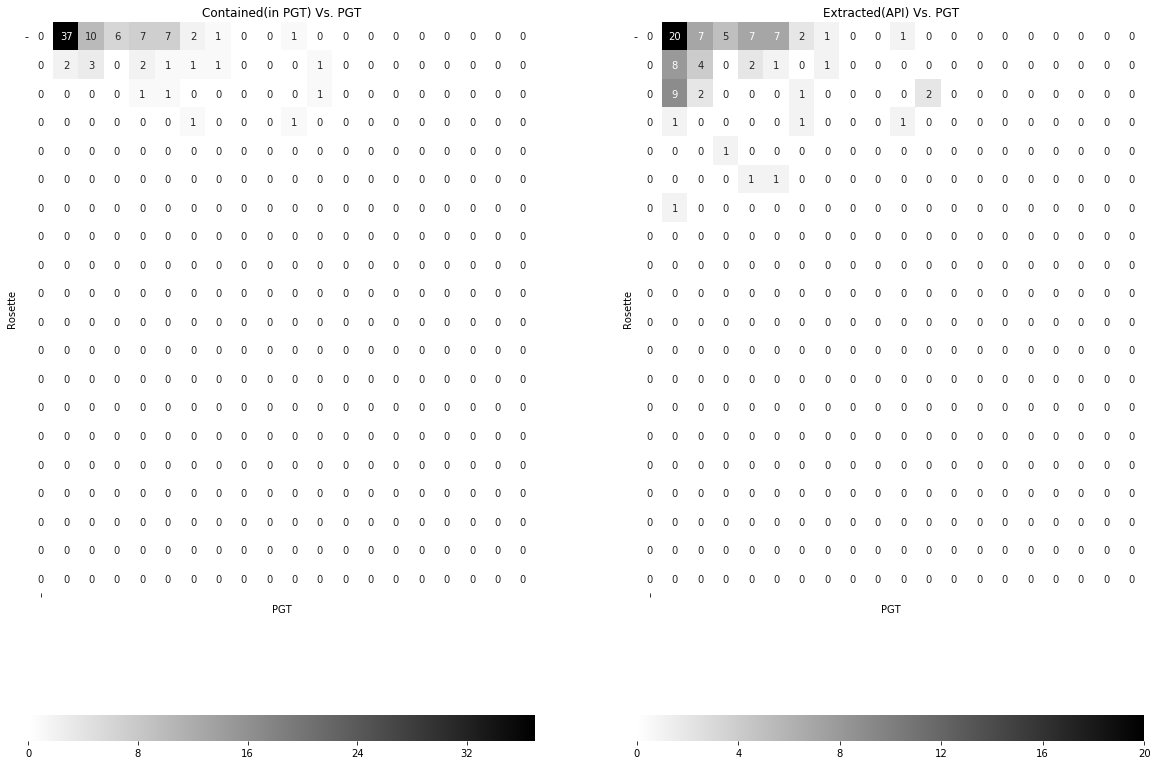

C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ResourceWarning: unclosed file <_io.BufferedWriter name='data/numpy_matrices/Person Employee or Member of^-1-100-matrix_cont.dat'>
C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ResourceWarning: unclosed file <_io.BufferedWriter name='data/numpy_matrices/Person Employee or Member of^-1-100-matrix_extr.dat'>


In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

# Contained
sns.heatmap(matrix_cont, ax=ax1, fmt='.0f', cmap='gist_gray_r', xticklabels = [""], yticklabels = [""], annot = True, cbar_kws={"orientation": "horizontal"})
ax1.set_ylabel('Rosette')    
ax1.set_xlabel('PGT')
ax1.set_title('Contained(in PGT) Vs. PGT')

# Extracted
sns.heatmap(matrix_extr, ax=ax2, fmt='.0f', cmap='gist_gray_r', xticklabels = [""], yticklabels = [""], annot = True, cbar_kws={"orientation": "horizontal"})
ax2.set_ylabel('Rosette')    
ax2.set_xlabel('PGT')
ax2.set_title('Extracted(API) Vs. PGT')

plt.show()
fig.savefig("data/img/{}-{}.png".format(relation,n))

matrix_cont.dump('data/numpy_matrices/{}-{}-matrix_cont.dat'.format(relation,n))
matrix_extr.dump('data/numpy_matrices/{}-{}-matrix_extr.dat'.format(relation,n))

C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: ResourceWarning: unclosed file <_io.BufferedWriter name='data/numpy_matrices/Person Employee or Member of^-1-100-matrix_cont.dat'>
  
C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.BufferedWriter name='data/numpy_matrices/Person Employee or Member of^-1-100-matrix_extr.dat'>
  from ipykernel import kernelapp as app


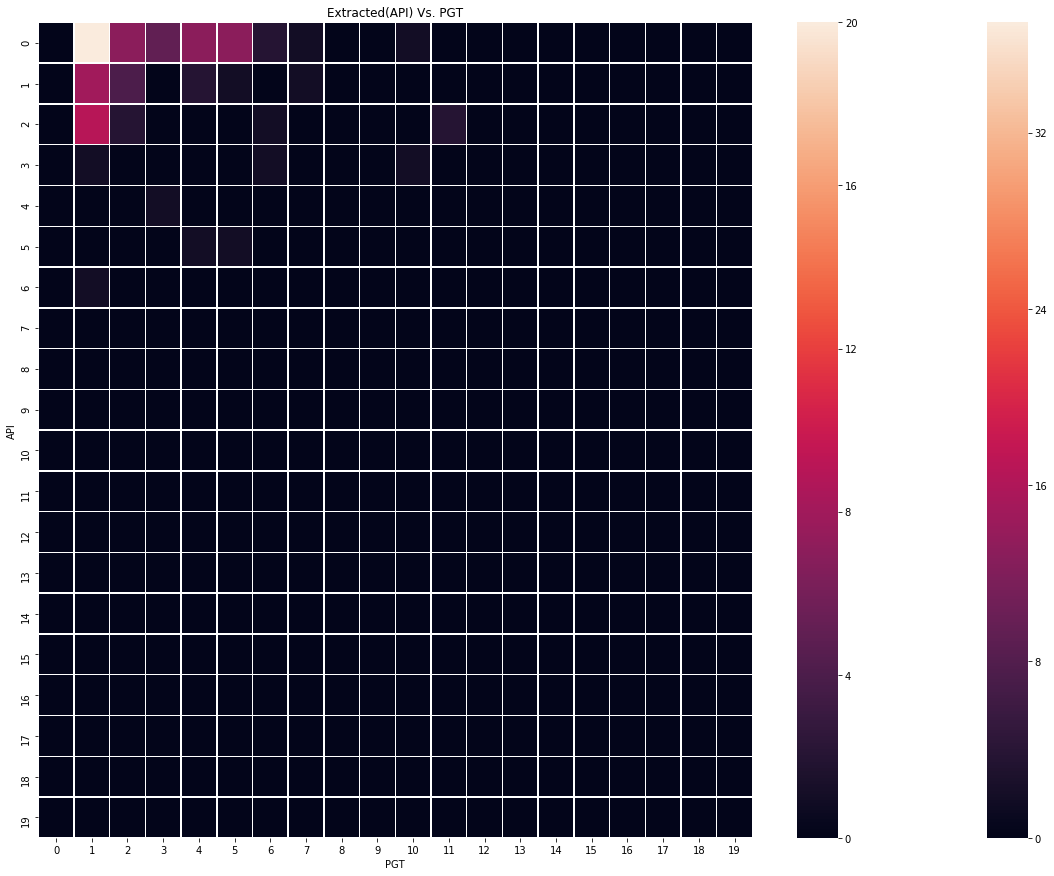

In [23]:
import seaborn as sns

fig1 = sns.heatmap(matrix_cont, linewidth=0.5)
fig2 = sns.heatmap(matrix_extr, linewidth=0.5)

fig1.set_title('Contained(in PGT) Vs. PGT')
fig2.set_title('Extracted(API) Vs. PGT')
fig1.set(xlabel='PGT', ylabel='API')
fig2.set(xlabel='PGT', ylabel='API')

# fig1.get_figure().savefig("data/img/{}-{}-matrix_cont.png".format(relation,n))
# fig2.get_figure().savefig("data/img/{}-{}-matrix_extr.png".format(relation,n))

matrix_cont.dump('data/numpy_matrices/{}-{}-matrix_cont.dat'.format(relation,n))
matrix_extr.dump('data/numpy_matrices/{}-{}-matrix_extr.dat'.format(relation,n))

In [ ]:
fig1.set(xlabel='PGT', ylabel='API')
fig1.set_title('Contained(in PGT) Vs. PGT')
fig1.get_figure()

In [ ]:
fig2.set(xlabel='PGT', ylabel='API')
fig2.set_title('Extracted(API) Vs. PGT')
fig2.get_figure()

## Testing

In [ ]:
u = Utils()
u.id_to_name("Q484427")